In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import transforms
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image

In [2]:
def get_train_val(filepath: str, val_size=0.2):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1] = int(row[1])-1
            new_row = [row[0], row[1]]
            data.append(new_row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id'])
    train_df, val_df = train_test_split(df, test_size=val_size, stratify=df['class_id'], shuffle=True, random_state=42)
    return train_df, val_df

def load_and_transform_image(image_path, transformations):
    transform = transforms.Compose(transformations)
    image = Image.open(image_path).convert('RGB')  # Convert all images to RGB
    return transform(image)

def create_dataset(df, base_path, transformations):
    images_tensors = []
    y = []
    for row in df.values.tolist():
        image_id, class_id = row[0], row[1]
        image_path = f"{base_path}{image_id}.jpg" 
        image_tensor = load_and_transform_image(image_path, transformations)
        images_tensors.append(image_tensor)
        y.append(class_id)
    
    X = torch.stack(images_tensors)
    y = torch.tensor(np.array(y))
    return X, y

def get_test(filepath: str):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1] = int(row[1])-1
            new_row = [row[0], row[1]]
            data.append(new_row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id'])
    return df

In [3]:
df_train, df_val = get_train_val('datasets/annotations/trainval.txt')
transformations = [
    transforms.Resize((224, 224)),             # Resize the images to 224x224 pixels
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
]
X_train, y_train = create_dataset(df_train, base_path='datasets/images/', transformations=transformations)
X_val, y_val = create_dataset(df_val, base_path='datasets/images/', transformations=transformations)

In [4]:
(X_train.shape, y_train.shape)

(torch.Size([2944, 3, 224, 224]), torch.Size([2944]))

In [5]:
df_test = get_test(filepath='datasets/annotations/test.txt')
transformations = [
    transforms.Resize((224, 224)),             # Resize the images to 224x224 pixels
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
]
X_test, Y_test = create_dataset(df_test, base_path='datasets/images/', transformations=transformations)

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):

        images, labels = batch 
        out = self(images)
        with torch.no_grad():
            loss = F.cross_entropy(out, labels)   
            acc = accuracy(out, labels)           
        return {'loss': loss.detach(), 'acc': acc}

In [10]:
# Function to disable the gradient computation for the initial layers of the network.
def set_parameter_requires_grad(model, layer_freezing_depth, fine_tune_last_layer_only=True):
    if fine_tune_last_layer_only:
        for name, param in model.named_parameters():
            if "fc" not in name:  # The final layer is named 'fc'
                param.requires_grad = False  # NOTE: Freezes all parameters except the final layer
            else:
                param.requires_grad = True  # NOTE: Keeps the final layer trainable
        return
    
    child_counter = 0
    for child in model.children():
        if child_counter < layer_freezing_depth:
            for param in child.parameters():
                param.requires_grad = False  # NOTE: Freezes the parameters so they won't update during training
        else:
            for param in child.parameters():
                param.requires_grad = True
        child_counter += 1


# Creates an optimizer that applies different learning rates to different layers
def get_optimizer(model, base_lr):
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Assign different learning rates to different layers
            if 'fc' in name:
                params_to_update.append({'params': param, 'lr': base_lr * 10})  # Higher learning rate for the final layer
            else:
                params_to_update.append({'params': param, 'lr': base_lr})  # Base learning rate for other layers
    return torch.optim.Adam(params_to_update)

    
class DogsCatsCnnModelResNet(ImageClassificationBase):
    def __init__(self, resnet=18, layer_freezing_depth=None, fine_tune_last_layer_only=True, fine_tune_bn=True):
        
        super().__init__()
        if resnet == 18:
            self.network = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        elif resnet == 34:
            self.network = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        else:
            raise ValueError
            
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 37)
        set_parameter_requires_grad(self.network, layer_freezing_depth, fine_tune_last_layer_only)

        # Optionally fine-tune batch-norm parameters
        if not fine_tune_bn:
            for module in self.modules():
                if isinstance(module, nn.BatchNorm2d):
                    module.eval()  # Use running mean/variance for BatchNorm
                    for param in module.parameters():
                        param.requires_grad = False  # Do not update BatchNorm parameters
    
    def forward(self, xb):
        return self.network(xb)  # Output raw logits directly
    
@torch.no_grad()
def evaluate(model: ImageClassificationBase, X_val, Y_val):
    model.eval()
    batch = [X_val, Y_val]
    outputs = model.validation_step(batch)
    return outputs

In [30]:
def augment_batch(batch):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    ])
    images, labels = batch
    augmented_images = torch.stack([transform(image) for image in images])
    return augmented_images, labels

def fit(model: ImageClassificationBase, epochs, lr, X_train, Y_train, X_val, Y_val, batch_size=32, opt_func=torch.optim.Adam, augment=False, use_scheduler=False):

    history = {
        'val': [],
        'train': []
    }
    optimizer = opt_func(model.parameters(), lr)
    if use_scheduler:
        optimizer = get_optimizer(model, lr)  # Use custom optimizer with different learning rates

        # Optionally add a learning rate scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Create TensorDataset and DataLoader for training data
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Evaluate on no training first
    result_val = evaluate(model, X_val, Y_val)
    result_train = evaluate(model, X_train, Y_train)
    history['val'].append(result_val)
    history['train'].append(result_train)
    print(f"Epoch 0, val: {result_val}")
    print(f"Epoch 0, train: {result_train}")

    min_loss = np.inf
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
                
        # Training Phase 
        model.train()
        train_losses = []
        for i, batch in enumerate(train_loader):
            if augment:
                batch = augment_batch(batch)
            print(f"  - Batch {i}/{int(len(X_train) / batch_size)}")
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        if use_scheduler:
            scheduler.step()

        result_val = evaluate(model, X_val, Y_val)
        result_train = evaluate(model, X_train, Y_train)
        history['val'].append(result_val)
        history['train'].append(result_train)
        print(f"    > val: {result_val}")
        print(f"    > train: {result_train}")

        if result_val['loss'] < min_loss:
            min_loss = result_val['loss']
            best_model = model
        
    return best_model, history

In [12]:
def plot_results(history):
    val_hist = history['val']
    train_hist = history['train']
    val_loss = [d['loss'] for d in val_hist]
    val_acc = [d['acc'] for d in val_hist]
    train_loss = [d['loss'] for d in train_hist]
    train_acc = [d['acc'] for d in train_hist]

    plt.style.use('dark_background')

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Update')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.xlabel('Update')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [66]:
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 128
lr = 0.00025

model_resnet_34 = DogsCatsCnnModelResNet(resnet=34, layer_freezing_depth=0, fine_tune_last_layer_only=False)
best_model, history = fit(model_resnet_34, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, opt_func)

Epoch 0, val: {'loss': tensor(3.8013), 'acc': tensor(0.0245)}
Epoch 0, train: {'loss': tensor(3.8343), 'acc': tensor(0.0251)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.6136), 'acc': tensor(0.8179)}
    > train: {'loss': tensor(0.3499), 'acc': tensor(0.9168)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

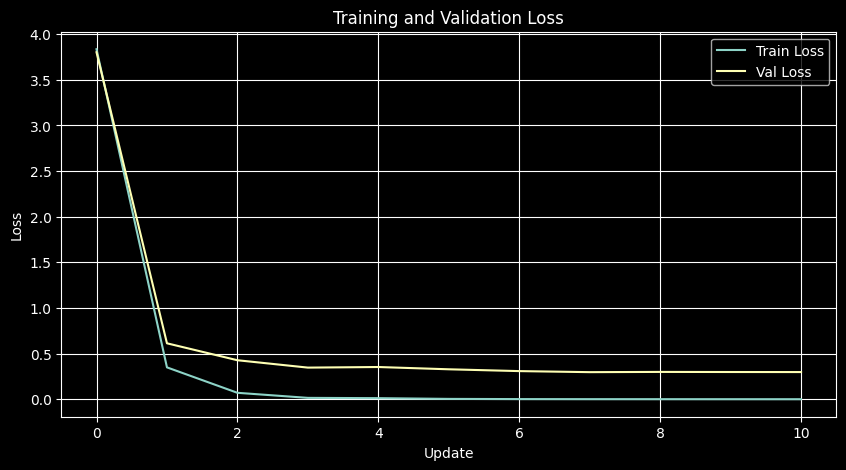

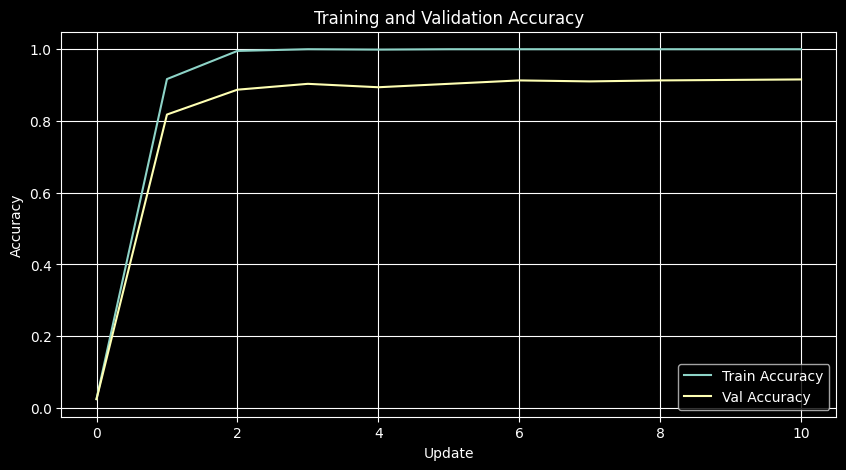

In [67]:
plot_results(history)

In [71]:
evaluate(best_model, X_test, Y_test)

{'loss': tensor(0.3402), 'acc': tensor(0.9049)}

In [81]:
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 128
lr = 0.00025

model_resnet_34 = DogsCatsCnnModelResNet(resnet=34, layer_freezing_depth=None, fine_tune_last_layer_only=True)
best_model, history = fit(model_resnet_34, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, opt_func, augment=False)

Epoch 0, val: {'loss': tensor(3.9105), 'acc': tensor(0.0136)}
Epoch 0, train: {'loss': tensor(3.9311), 'acc': tensor(0.0136)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(3.2175), 'acc': tensor(0.1359)}
    > train: {'loss': tensor(3.2075), 'acc': tensor(0.1729)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

In [15]:
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 128
lr = 0.00025

model_resnet_34 = DogsCatsCnnModelResNet(resnet=34, layer_freezing_depth=5, fine_tune_last_layer_only=False)
best_model, history = fit(model_resnet_34, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, opt_func, augment=False)

Epoch 0, val: {'loss': tensor(3.8009), 'acc': tensor(0.0448)}
Epoch 0, train: {'loss': tensor(3.8052), 'acc': tensor(0.0333)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.5038), 'acc': tensor(0.8709)}
    > train: {'loss': tensor(0.2643), 'acc': tensor(0.9524)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

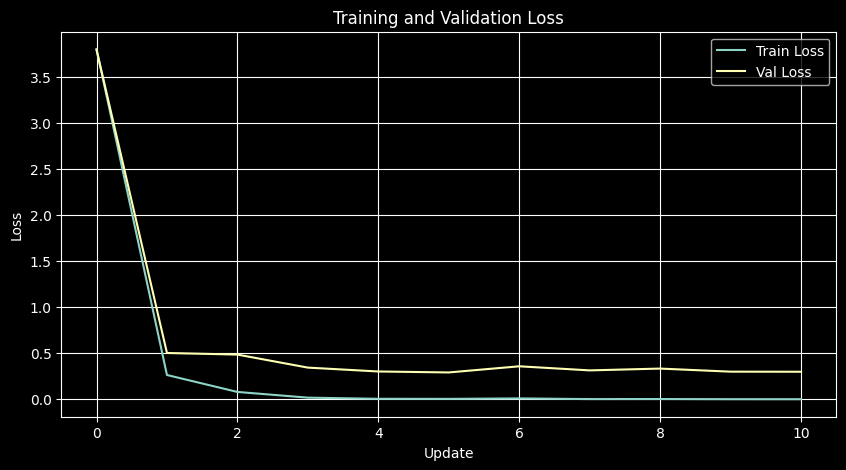

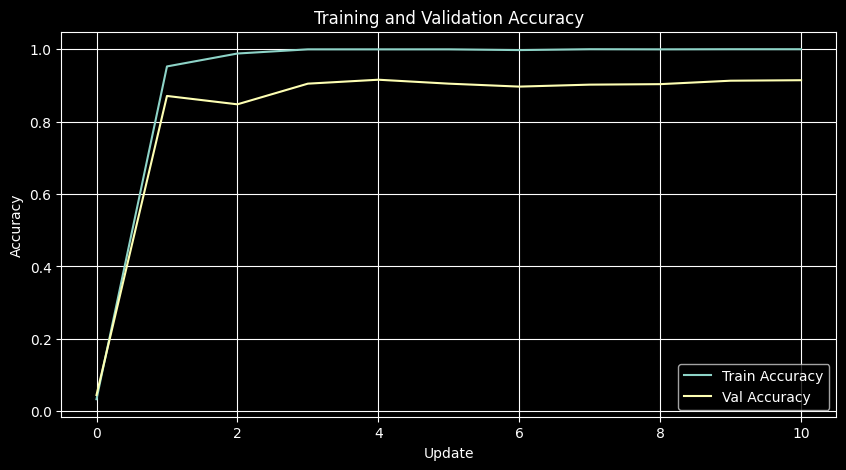

In [16]:
plot_results(history)

In [20]:
evaluate(best_model, X_test, Y_test)

{'loss': tensor(0.3786), 'acc': tensor(0.8929)}

In [16]:
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 128
lr = 0.0001

model_resnet_34 = DogsCatsCnnModelResNet(resnet=34, layer_freezing_depth=0, fine_tune_last_layer_only=False, fine_tune_bn=True)
best_model, history = fit(model_resnet_34, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, opt_func, augment=False, use_scheduler=True)

Epoch 0, val: {'loss': tensor(3.8878), 'acc': tensor(0.0353)}
Epoch 0, train: {'loss': tensor(3.8802), 'acc': tensor(0.0275)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.4615), 'acc': tensor(0.8886)}
    > train: {'loss': tensor(0.3062), 'acc': tensor(0.9365)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

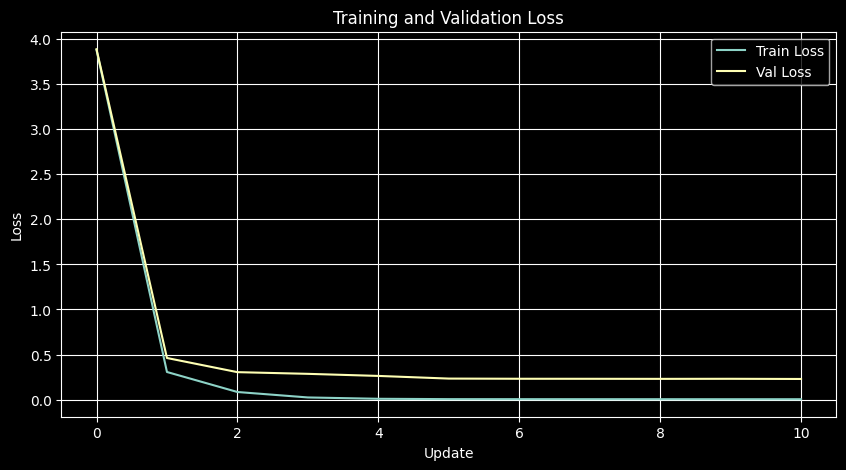

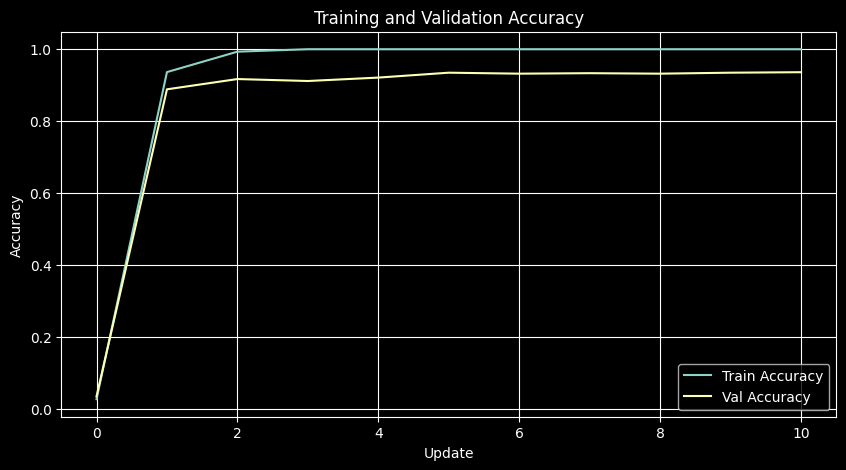

In [17]:
plot_results(history)

In [19]:
evaluate(best_model, X_test, Y_test)

{'loss': tensor(0.3136), 'acc': tensor(0.9065)}

Epoch 0, val: {'loss': tensor(3.8981), 'acc': tensor(0.0367)}
Epoch 0, train: {'loss': tensor(3.8888), 'acc': tensor(0.0377)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.4944), 'acc': tensor(0.8587)}
    > train: {'loss': tensor(0.2587), 'acc': tensor(0.9538)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

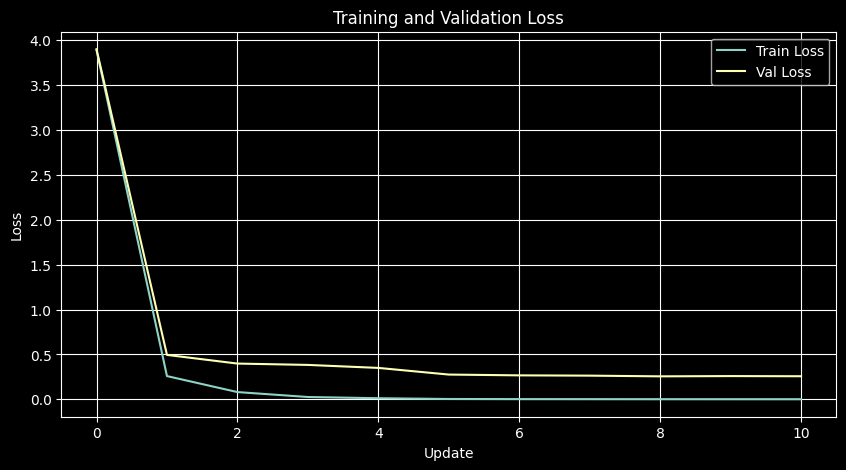

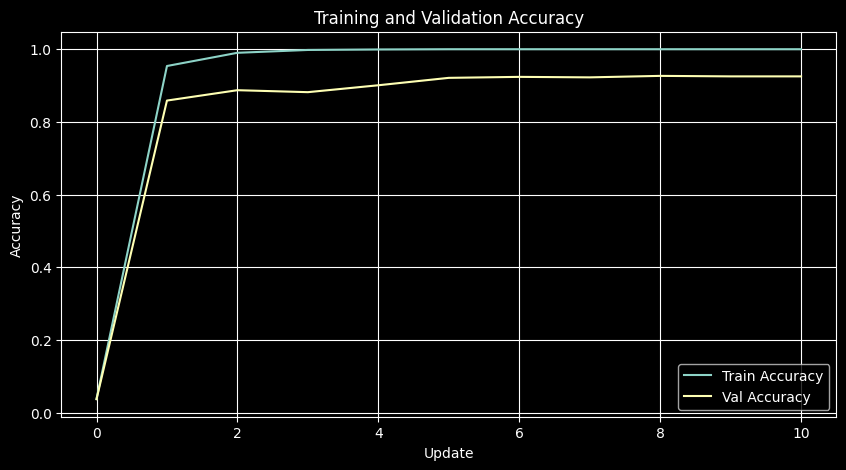

In [28]:
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 128
lr = 0.00025

model_resnet_34 = DogsCatsCnnModelResNet(resnet=34, layer_freezing_depth=0, fine_tune_last_layer_only=False, fine_tune_bn=False)
best_model, history = fit(model_resnet_34, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, opt_func, augment=False, use_scheduler=False)
plot_results(history)


In [29]:
evaluate(best_model, X_test, Y_test)

{'loss': tensor(0.3604), 'acc': tensor(0.9049)}

Epoch 0, val: {'loss': tensor(3.8970), 'acc': tensor(0.0190)}
Epoch 0, train: {'loss': tensor(3.8825), 'acc': tensor(0.0149)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.4393), 'acc': tensor(0.8995)}
    > train: {'loss': tensor(0.2972), 'acc': tensor(0.9351)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

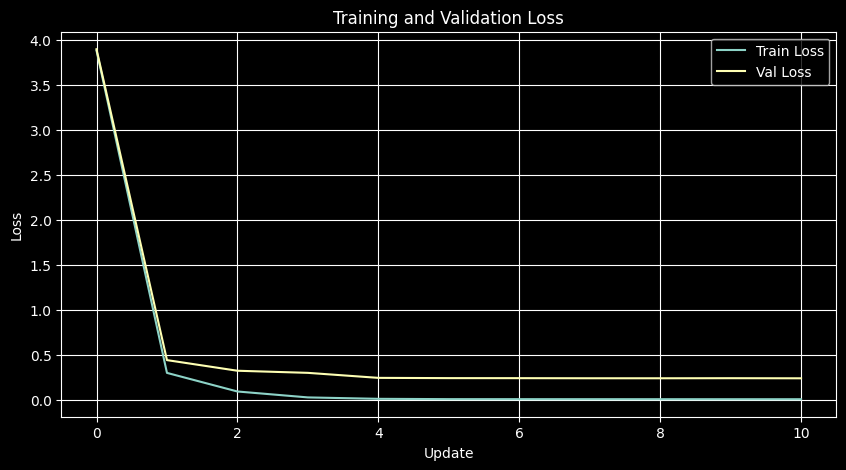

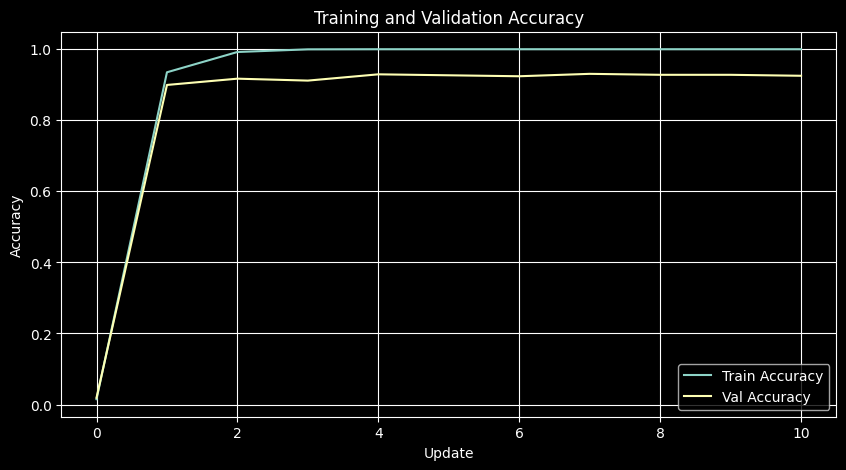

In [31]:
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 128
lr = 0.0001

model_resnet_34 = DogsCatsCnnModelResNet(resnet=34, layer_freezing_depth=0, fine_tune_last_layer_only=False, fine_tune_bn=False)
best_model, history = fit(model_resnet_34, num_epochs, lr, X_train, y_train, X_val, y_val, batch_size, opt_func, augment=False, use_scheduler=True)
plot_results(history)